## 「ベイズ推論による機械学習入門」P.128 ポアソン混合モデルにおけるギブスサンプリング

## ポアソン混合モデル

* クラスタkの観測モデルをポアソン分布とする（式1）。
* ポアソン分布のパラメータ $\lambda$ の事前分布をガンマ分布（共役事前分布）とする（式2）。
* 各クラスタの混合比率 $\pi$ はカテゴリ分布のため、事前分布をK次元のディリクレ分布（共役事前分布）とする（式3）。
* K個の観測モデルを各データ点に割り当てる潜在変数Sをカテゴリ分布とする（式4）。
* K個のポアソン分布に対して混合比率 $\pi$ を使って加重平均を取って各データ点に対する確率を求める（式5）。

$$\mathcal{p}(\mathcal{x}_n|\lambda_k) = Poi(\mathcal{x}_n|\lambda_k)\quad (1)$$

$$\mathcal{p}(\lambda_k) = Gam(\lambda_k|a, b)\quad (2)$$

$$\mathcal{p}(\boldsymbol\pi) = Dir(\boldsymbol\pi|\boldsymbol\alpha)\quad (3)$$

$$\mathcal{p}(s_n|\pi) = Cat(s_n|\pi)\quad (4)$$

$$\sum_{k=1}^K \pi_k Poi(x_n|\lambda_k)\quad (5)$$

In [1]:
using Distributions
using Plots
using StatsBase

## 真のモデル

In [2]:
λ_true = [10.0, 25.0, 40.0]
π_true = [0.35, 0.3, 0.35]
true_model = MixtureModel([Poisson(λ) for λ in λ_true], π_true)

MixtureModel{Poisson{Float64}}(K = 3)
components[1] (prior = 0.3500): Poisson{Float64}(λ=10.0)
components[2] (prior = 0.3000): Poisson{Float64}(λ=25.0)
components[3] (prior = 0.3500): Poisson{Float64}(λ=40.0)


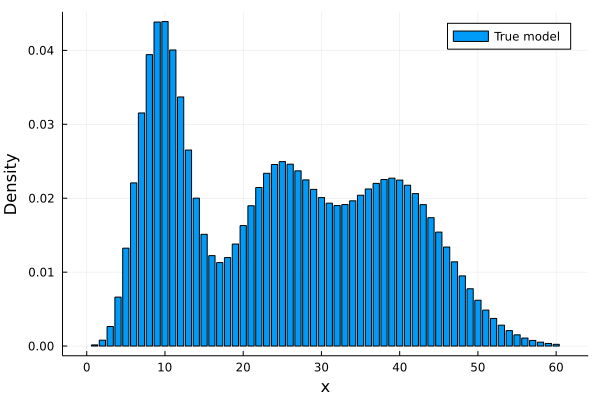

In [3]:
bar(x -> pdf(true_model, x), 1:60, label="True model", xlabel="x", ylabel="Density")

## 観測データを生成

潜在変数Sを生成し、各データに割り当てられたクラスタに従って観測データXを生成する。

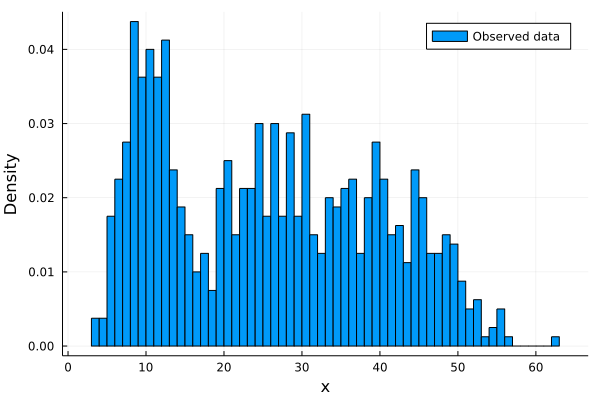

In [4]:
N = 800
mult_obs = Multinomial(1, π_true)
S_obs = rand(mult_obs, N)
cluster_num = mapslices(argmax, S_obs, dims=1)

data = Float64[]
for (idx, val) in enumerate(λ_true)
    n = count(cluster_num .== idx)
    poi_obs = Poisson(val)
    data = vcat(data, rand(poi_obs, n))
end

bins = 80
histogram(data; bins, label="Observed data", xlabel="x", ylabel="Density", norm=:pdf)

## ギブスサンプリング

## 導出

ポアソン混合モデルの事後分布からパラメータをサンプリングするアルゴリズムを導出する。

$\boldsymbol X$が観測された後の条件付き分布は以下になる。

$$\mathcal{p}(\boldsymbol S,\boldsymbol \lambda,\boldsymbol \pi,\boldsymbol X)$$

混合分布では、潜在変数とパラメータを分けてサンプリングすることで、簡単な確率分布が得られることから、以下より潜在変数とパラメータををサンプリングすることとする。

$$\boldsymbol S \sim \mathcal{p}(\boldsymbol S|\boldsymbol X, \boldsymbol \lambda,\boldsymbol \pi) $$

$$\boldsymbol \lambda,\boldsymbol \pi \sim \mathcal{p}(\boldsymbol \lambda,\boldsymbol \pi|\boldsymbol X, \boldsymbol S) $$

### 潜在変数$\boldsymbol S$ をサンプリングするための条件分布を求める

\begin{eqnarray}
\mathcal{p}(\boldsymbol S|\boldsymbol X,\boldsymbol \lambda,\boldsymbol \pi) &=& \frac{p(\boldsymbol S,\boldsymbol X, \boldsymbol \lambda,\boldsymbol \pi)}{p(\boldsymbol X, \boldsymbol \lambda,\boldsymbol \pi)}\\
&\propto& p(\boldsymbol S,\boldsymbol X, \boldsymbol \lambda,\boldsymbol \pi)\\
&=& p(\boldsymbol X|\boldsymbol S, \boldsymbol \lambda)p(\boldsymbol S|\boldsymbol \pi)p(\boldsymbol \lambda)p(\boldsymbol \pi)\\
&\propto& p(\boldsymbol X|\boldsymbol S, \boldsymbol \lambda)p(\boldsymbol S|\boldsymbol \pi)\\
&=& \prod_{n=1}^{N} p(x_n|s_n, \boldsymbol \lambda)p(s_n|\boldsymbol \pi) \\
&=& \prod_{n=1}^{N} \Bigr\{ \prod_{k=1}^{K}Poi(x_n|\lambda_k)^{s_{n,k}}Cat(\boldsymbol s_n|\boldsymbol \pi) \Bigr\}\\
\end{eqnarray}

$\boldsymbol s_n$をサンプリングするための確率分布を計算する。前の項は、

\begin{eqnarray}
\ln \mathcal{p}(x_n|\boldsymbol s_n,\boldsymbol \lambda) &=& \ln \Bigr\{\prod_{n=1}^{N}Poi(x_n|\lambda_k)^{s_{n,k}} \Bigr\} \\
&=& \sum_{k=1}^{K}s_{n,k}\ln Poi (x_n|\lambda_k) \\
&=& \sum_{k=1}^{K}s_{n,k}\ln\frac{\lambda_k^{x_n}}{x_n!}\exp(-\lambda_k)\\
&=& \sum_{k=1}^{K}s_{n,k}(x_n \ln \lambda_k - \ln x_n! - \lambda_k)\\
&=& \sum_{k=1}^{K}s_{n,k} x_n \ln \lambda_k - \sum_{k=1}^{K} \ln s_{n,k}x_n! - \sum_{k=1}^{K} s_{n,k}\lambda_k \\
&=& \sum_{k=1}^{K} s_{n,k}(x_n \ln\lambda_k - \lambda_k) + const. \\
\end{eqnarray}

また、後ろの項は

\begin{eqnarray}
\ln \mathcal{p}(\boldsymbol s_n|\boldsymbol \pi) &=& \ln Cat(\boldsymbol s_n|\boldsymbol \pi)\\
&=& \ln \prod_{k=1}^{K}\pi_k^{s_{n,k}} \\
&=& \sum_{k=1}^{K}s_{n,k}\ln\pi_k \\
\end{eqnarray}

まとめると、

\begin{eqnarray}
\ln \mathcal{p}(s_n|\boldsymbol X, \boldsymbol \lambda, \boldsymbol \pi) &=& \ln \mathcal{p}(x_n|\boldsymbol s_n, \boldsymbol \lambda) + \ln \mathcal{p}(\boldsymbol s_n|\boldsymbol \pi) + const.\\
&=& \sum_{k=1}^{K} s_{n,k}(x_n \ln\lambda_k - \lambda_k) + \sum_{k=1}^{K}s_{n,k}\ln\pi_k + const. \\
&=& \sum_{k=1}^{K}s_{n,k}(x_n\ln\lambda_k - \lambda_k + \ln\pi_k) + const. \\
&=& \sum_{k=1}^{K}s_{n,k}\ln\eta_{n,k} + const. \quad \eta_{n,k} \propto \exp(x_n\ln\lambda_k - \lambda_k + \ln\pi_k) \\
\end{eqnarray}

したがって、$\boldsymbol s_n$の条件付き分布は以下のようになる。

\begin{eqnarray}
\mathcal{p}(s_n|\boldsymbol X, \boldsymbol \lambda, \boldsymbol \pi) &=& \prod_{k=1}^{K} \eta_{n,k}^{s_{n,k}}\\
&=& Cat(\boldsymbol s_n|\boldsymbol \eta_n) \quad \boldsymbol \eta_n =(\eta_{n,1},\eta_{n,2},....,\eta_{n,K}) \quad (1) \\
\end{eqnarray}

### $\boldsymbol \lambda$と$\boldsymbol \pi$をサンプリングするための条件分布を求める

\begin{eqnarray}
\mathcal{p}(\boldsymbol \lambda,\boldsymbol \pi|\boldsymbol X, \boldsymbol S) &=& \frac{p(\boldsymbol X, \boldsymbol S,\boldsymbol \lambda,\boldsymbol \pi)}{p(\boldsymbol X, \boldsymbol S)}\\
&\propto& p(\boldsymbol X, \boldsymbol S,\boldsymbol \lambda,\boldsymbol \pi)\\
&=& p(\boldsymbol X|\boldsymbol S, \boldsymbol \lambda)p(\boldsymbol S|\boldsymbol \pi)p(\boldsymbol \lambda)p(\boldsymbol \pi)\\
\end{eqnarray}

また、左辺の条件付き分布を分解し、以下のように変形する。

\begin{eqnarray}
\mathcal{p}(\boldsymbol \lambda|\boldsymbol X, \boldsymbol S)\mathcal{p}(\boldsymbol \pi|\boldsymbol X, \boldsymbol S) &=& p(\boldsymbol X|\boldsymbol S, \boldsymbol \lambda)p(\boldsymbol S|\boldsymbol \pi)p(\boldsymbol \lambda)p(\boldsymbol \pi)\\
\end{eqnarray}

はじめに$\boldsymbol \lambda$をサンプリングするための条件分布を求める。

\begin{eqnarray}
\mathcal{p}(\boldsymbol \lambda|\boldsymbol X, \boldsymbol S) &=& \frac{\mathcal{p}(\boldsymbol X|\boldsymbol S, \boldsymbol \lambda)\mathcal{p}(\boldsymbol S|\boldsymbol \pi)\mathcal{p}(\boldsymbol \lambda)\mathcal{p}(\boldsymbol \pi)}{\mathcal{p}(\boldsymbol \pi|\boldsymbol X, \boldsymbol S)}\\
\ln p(\boldsymbol \lambda|\boldsymbol X, \boldsymbol S) &=& \ln p(\mathcal{p}(\boldsymbol X|\boldsymbol S, \boldsymbol \lambda) + \ln p(\boldsymbol S|\boldsymbol \pi) + \ln p(\boldsymbol \lambda) + \ln p(\boldsymbol \pi) - \ln p(\boldsymbol \pi|\boldsymbol X, \boldsymbol S)\\
&=& \ln p(\mathcal{p}(\boldsymbol X|\boldsymbol S, \boldsymbol \lambda) + \ln p(\boldsymbol \lambda) + const.\\
&=& \sum_{n=1}^{N}\sum_{k=1}^{K}s_{n,k}\ln Poi(x_n|\lambda_k) + \sum_{k=1}^{K}\ln Gam(\lambda_k|a,b)\\
&=& \sum_{k=1}^{K}\Bigr\{\sum_{n=1}^{N}s_{n,k}\ln \frac{\lambda_k^{x_n}}{x_n!}\exp(-\lambda_k) + \ln C_G(a,b)\lambda_k^{a-1}\exp(-b\lambda_k)\Bigr\}\\
&=& \sum_{k=1}^{K} \Bigr\{\sum_{n=1}^{N}s_{n,k}(x_n \ln x_n - \ln x_n! - \lambda_k) + \ln C_G(a,b) + (a-1)\ln \lambda_k - b \lambda_k \Bigr\} + const.\\
&=& \sum_{k=1}^{K} \Bigr\{(\sum_{n=1}^{N}s_{n,k}x_n + a - 1)\ln \lambda_k - (\sum_{n=1}^{N}s_{n,k} + b)\lambda_k \Bigr\} + const.\\
\end{eqnarray}

$\hat{a}_k$、$\hat{b}_k$を以下とすると、

$$\hat{a}_k = \sum_{n=1}^{N}s_{n,k}x_n + a$$
$$\hat{b}_k = \sum_{n=1}^{N}s_{n,k} + b$$

\begin{eqnarray}
\ln p(\boldsymbol \lambda|\boldsymbol X, \boldsymbol S) &=& \sum_{k=1}^{K}\Bigr\{(\hat{a}_k - 1) \ln \lambda_k - \hat{b}_k \lambda_k \Bigr\} + const.\\
p(\boldsymbol \lambda|\boldsymbol X, \boldsymbol S) &=& \prod_{k=1}^{K} C_G(\hat{a}_k,\hat{b}_k)\lambda_k^{\hat{a}_k-1}\exp(-\hat{b}_k\lambda_k)\\
&=& \prod_{k=1}^{K} Gam(\lambda_k|\hat{a}_k,\hat{b}_k) \quad (2)\\
\end{eqnarray}

したがって、$\boldsymbol \lambda$の条件分布は$\hat{a}_k$、$\hat{b}_k$をパラメータに持つガンマ分布になる。

次に$\boldsymbol \pi$をサンプリングするための条件分布を求める。

\begin{eqnarray}
\mathcal{p}(\boldsymbol \pi|\boldsymbol X, \boldsymbol S) &=& \frac{\mathcal{p}(\boldsymbol X|\boldsymbol S, \boldsymbol \lambda)\mathcal{p}(\boldsymbol S|\boldsymbol \pi)\mathcal{p}(\boldsymbol \lambda)\mathcal{p}(\boldsymbol \pi)}{\mathcal{p}(\boldsymbol \lambda|\boldsymbol X, \boldsymbol S)}\\
\ln p(\boldsymbol \pi|\boldsymbol X, \boldsymbol S) &=& \ln p(\mathcal{p}(\boldsymbol X|\boldsymbol S, \boldsymbol \lambda) + \ln p(\boldsymbol S|\boldsymbol \pi) + \ln p(\boldsymbol \lambda) + \ln p(\boldsymbol \pi) - \ln p(\boldsymbol \lambda|\boldsymbol X, \boldsymbol S)\\
&=& \ln p(\boldsymbol S|\boldsymbol \pi) + \ln p(\boldsymbol \pi) + const. \\
&=& \sum_{n=1}^{N}\ln Cat(s_n|\boldsymbol \pi) + \ln Dir(\boldsymbol \pi|\boldsymbol \alpha)\\
&=& \sum_{n=1}^{N}\ln \prod_{k=1}^{K} \pi_k^{s_{n,k}} + \ln C_D(\boldsymbol \alpha) \prod_{k=1}^{K}\pi_k^{\alpha_k - 1} + const.\\
&=& \sum_{n=1}^{N}\sum_{k=1}^{K}s_{n,k}\ln\pi_k + \ln C_D(\boldsymbol \alpha) + \sum_{k=1}^{K}(\alpha_k - 1)\ln \pi_k + const. \\
&=& \sum_{k=1}^{K}(\sum_{n=1}^{N}s_{n,k} + \alpha_k - 1)\ln \pi_k + const.\\
\end{eqnarray}


$\hat{\alpha}_k$を以下とすると、

$$\hat{\alpha}_k = \sum_{n=1}^{N}s_{n,k} + \alpha_k$$

\begin{eqnarray}
\ln p(\boldsymbol \pi|\boldsymbol X, \boldsymbol S) &=& \sum_{k=1}^{K}(\hat{\alpha}_k - 1)\ln \pi_k + const.\\
p(\boldsymbol \pi|\boldsymbol X, \boldsymbol S) &=& C_D(\boldsymbol \alpha)\prod_{k=1}^{K}\pi_k^{\hat{\alpha}_k - 1}\\
&=& Dir(\boldsymbol \pi|\hat{\boldsymbol \alpha}) \quad\ \hat{\boldsymbol \alpha} = (\hat{\alpha}_1,\hat{\alpha}_2,...,\hat{\alpha}_K) \quad (3)\\
\end{eqnarray}

したがって、$\boldsymbol \pi$の条件分布は$\hat{\boldsymbol \alpha}$をパラメータに持つディリクレ分布になる。

## 実装

In [5]:
N = 800
K = 3
max_iter = 100

λ_sample = zeros(max_iter+1, K)
π_sample = zeros(max_iter+1, K)

λ_sample[1, :] = rand(K) .* (maximum(data) - minimum(data)) .+ minimum(data)
p = rand(K)
π_sample[1, :] = p ./ sum(p)
â = ones(K)
b̂ = ones(K)
α̂ = ones(K)

for i in 1:max_iter
    # 潜在変数の事後分布のパラメータを計算
    η_ = exp.(data' .* log.(λ_sample[i, :]) .- λ_sample[i, :] .+ π_sample[i, :]) # \eta + <TAB>
    η = η_ ./ sum(η_, dims=1) # 正規化
    s_sample = zeros(K, N)
    # 潜在変数をサンプル
    for n in 1:N
        cat = Multinomial(1, η[:, n])
        s_sample[:, n] = rand(cat, 1)
    end
　　　
    # λの事後分布のパラメータを計算
    â += sum(s_sample .* data', dims=2)
    b̂ += sum(s_sample, dims=2)
    # λをサンプル
    for k in 1:K
        gam = Gamma(â[k], 1 ./ b̂[k])
        λ_sample[i+1, k] = rand(gam, 1)[1]
    end
　　
    # πの事後分布のパラメータを計算
    α̂ += sum(s_sample, dims=2)
    # πをサンプル
    dir = Dirichlet(α̂[:])
    π_sample[i+1, :] = rand(dir, 1)
    
    if i % 10 == 1
        println("iteration: $i")
    end
end

iteration: 1
iteration: 11
iteration: 21
iteration: 31
iteration: 41
iteration: 51
iteration: 61
iteration: 71
iteration: 81
iteration: 91
  1.092648 seconds (3.83 M allocations: 234.279 MiB, 4.96% gc time, 87.67% compilation time)


## サンプルしたパラメータを使って分布を確認

┌ Info: Saved animation to 
│   fn = /Users/akifumiabe/Julia/BayesMLBook/poisson.gif
└ @ Plots /Users/akifumiabe/.julia/packages/Plots/T6yvp/src/animation.jl:114


Plots.AnimatedGif("/Users/akifumiabe/Julia/BayesMLBook/poisson.gif")
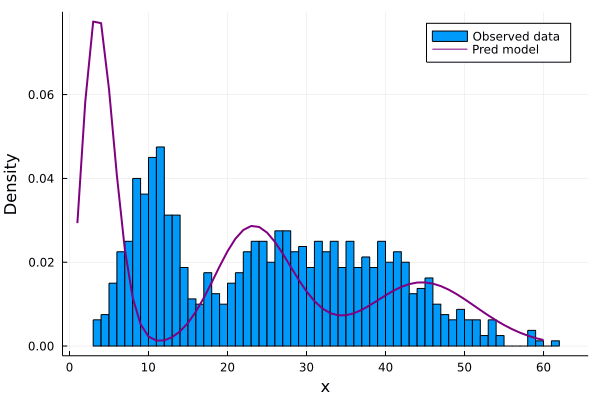

In [33]:
xs = 1:60
anim = @animate for i in 1:max_iter
    p = histogram(data; bins, norm=:pdf, label="Observed data", xlabel="x", ylabel="Density")
    d = MixtureModel([Poisson(λ) for λ in λ_sample[i, :]], π_sample[i, :])
    p = plot!(xs, pdf(d, xs), label="Pred model", linewidth=2, color="purple")
end

gif(anim, "poisson.gif", fps=10)

## 実装 改良版

In [9]:
N = 800
K = 3
max_iter = 100

s_sample = zeros(K, N)
λ_sample = zeros(max_iter+1, K)
π_sample = zeros(max_iter+1, K)

λ_sample[1, :] = rand(K) .* (maximum(data) - minimum(data)) .+ minimum(data)
p = rand(K)
π_sample[1, :] = p ./ sum(p)
â = ones(K)
b̂ = ones(K)
α̂ = ones(K)

η_ = zeros(K, N)

for i in 1:max_iter
    # 代入の際に .= を用いることで、ループが始まる前に確保した η_ の領域をループの際に使い回すことができる
    η_ .= exp.(data' .* log.(λ_sample[i, :]) .- λ_sample[i, :] .+ π_sample[i, :])
    η = η_ ./ sum(η_, dims=1)
    for n in 1:N
        cat = Multinomial(1, η[:, n])
        s_sample[:, n] = rand(cat)
    end
　　　
    â += vec(sum(s_sample .* data', dims=2))
    b̂ += vec(sum(s_sample, dims=2))
    for k in 1:K
        gam = Gamma(â[k], 1 ./ b̂[k])
        λ_sample[i+1, k] = rand(gam)[1]
    end
　　
    α̂ += vec(sum(s_sample, dims=2))
    dir = Dirichlet(α̂)
    π_sample[i+1, :] = rand(dir, 1)
    
    if i % 10 == 1
        println("iteration: $i")
    end
    
    # s_sample を構成する全ての要素をゼロに置き換える
    fill!(s_sample, zero(eltype(s_sample)))
    
end

iteration: 1
iteration: 11
iteration: 21
iteration: 31
iteration: 41
iteration: 51
iteration: 61
iteration: 71
iteration: 81
iteration: 91


┌ Info: Saved animation to 
│   fn = /Users/akifumiabe/Julia/BayesMLBook/poisson_v2.gif
└ @ Plots /Users/akifumiabe/.julia/packages/Plots/T6yvp/src/animation.jl:114


Plots.AnimatedGif("/Users/akifumiabe/Julia/BayesMLBook/poisson_v2.gif")
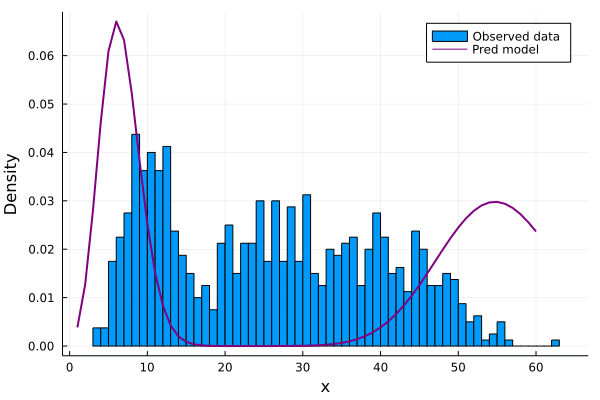

In [10]:
xs = 1:60
anim = @animate for i in 1:max_iter
    p = histogram(data; bins, norm=:pdf, label="Observed data", xlabel="x", ylabel="Density")
    d = MixtureModel([Poisson(λ) for λ in λ_sample[i, :]], π_sample[i, :])
    p = plot!(xs, pdf(d, xs), label="Pred model", linewidth=2, color="purple")
end

gif(anim, "poisson_v2.gif", fps=10)